# Plan



Generate some low dimensional dynamics
Then add space on top of that




In [20]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
from functools import partial
from mpl_toolkits import mplot3d

seaborn.set(font_scale=1.5,style='ticks')

In [21]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# Run with jax

In [22]:
dim = 4
nT = 9
x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(9)])

In [23]:
#plt.plot(x[:,1])
#plt.yscale('symlog')

In [24]:
Ahat = np.random.normal(size=(dim,dim))


In [25]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


In [26]:
def predict(Ahat,x,y,n,dim):
    Ahat = jnp.reshape(Ahat,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(Ahat,n),x)-y)**2)


predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
grad_predict_funs = [grad(i) for i in predict_funs]

In [27]:
predict_funs[1](A,x[0],x[1])

DeviceArray(4.440892e-15, dtype=float32)

# Now do it properly with constraints

In [28]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [29]:
def construct_M(skewM,dim):
    """ Perform Caley transform"""
    return (jnp.eye(dim) - skewM)@jnp.linalg.inv(jnp.eye(dim)+skewM)

In [30]:
def predict(T,x,y,n,dim):
    transition_matrix = jnp.reshape(T,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(transition_matrix,n),x)-y)**2)


#predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
#grad_predict_funs = [grad(i) for i in predict_funs]

In [31]:
def predict_all(params,x,dim,basis_tensor):

    err = 0
    nT = len(x)
    k = 0
    skewM = jnp.einsum('i...,i...',params,basis_tensor)
    M = construct_M(skewM,dim)
    #print(M.shape)
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict(M,x[start_state],x[pred_state],n_fwd,dim)
            k += 1
    mse = err/k
    print(mse)
    return mse


In [32]:
def grad_wrapper(params,x,dim,basis_tensor):
    grad = grad_predict_all(jnp.array(params),x,dim,basis_tensor)
    grad = np.array(grad)
    print(grad)
    return grad

In [33]:
def caley_transform(skewM,dim):
    """ Perform Caley transform"""
    return (np.eye(dim) - skewM)@np.linalg.inv(np.eye(dim)+skewM)

## Generate Data

# Get this to work with cell activity with structured noise

In [62]:
n_neurons = 120
dim = 3
nT = 9

frac_noise_dynamics = .3

x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])

x = frac_noise_dynamics*x #+ (1-frac_noise_dynamics)*np.random.normal(size=x.shape)


W = np.random.normal(size=(n_neurons,dim))
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [63]:
evals, evecs = np.linalg.eig(A)

In [64]:
evecs[:,0]

array([-0.60401338+0.j        , -0.25775479-0.50422277j,
       -0.26216465+0.49574126j])

<IPython.core.display.Javascript object>


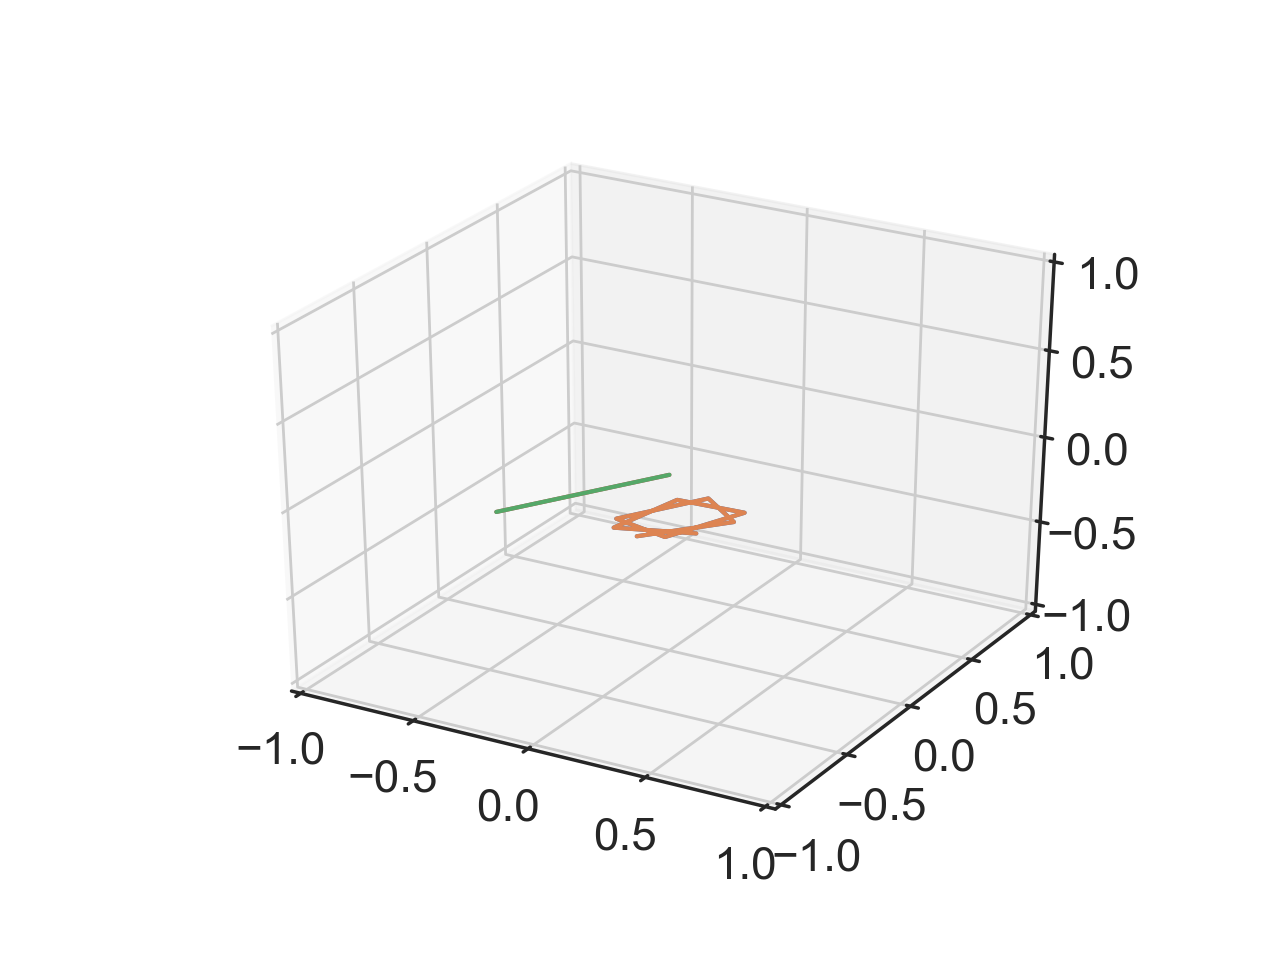

In [69]:

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(x[:,0,0],x[:,1,0],x[:,2,0])
ax.plot3D(x[:,0,0],x[:,1,0],x[:,2,0])

ax.plot3D(*np.vstack([np.zeros(3),evecs[:,0].real]).T,color='r')
ax.plot3D(*np.vstack([np.zeros(3),evecs[:,1].real]).T)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

plt.show()

In [269]:
def get_spatial_tuning(poke_pos,peak_loc,width):
    """"""
    #for i in range(9):
    distance_matrix = np.abs((poke_pos[peak_loc]-poke_pos)**2).sum(axis=1)
    fr = norm(scale=width).pdf(distance_matrix)
    return fr#distance_matrix
        
def get_task_tuning_line(seq,peak_loc,width):
    task_dists = np.abs(peak_loc-np.arange(9))
#     fr = norm(scale=width).pdf(task_dists)
    fr = np.sin(task_dists)
    return fr[seq]#task_dists[seq]#[task_dists[i] for i in seq]#fr#[fr[i] for i in seq]

In [130]:
from scipy.stats import norm


act_matrix = []
for nix in range(n_neurons):
    peak_space = np.random.randint(0,9)
    std_space = np.random.randint(1000,12000)
    
    lamda1 = get_spatial_tuning(poke_pos,peak_space,std_space)
    lamda1 = lamda1/np.max(lamda1)
    
    lamda2 = np.squeeze(x)@np.random.normal(size=(3))
    
    
    w1 = np.random.normal()
    w2 = np.random.normal()
    activity = 0*lamda1 + lamda2# + np.random.normal(scale=.1,size=9)
    act_matrix.append(activity.copy())
act_matrix = np.array(act_matrix).T

In [131]:
grad_predict_all = grad(predict_all)

In [132]:
from sklearn.decomposition import PCA

In [139]:
dim = 6
pca = PCA(n_components=dim)

In [172]:
pca_activity = pca.fit_transform(act_matrix)

In [142]:
n_params = int(dim*(dim-1)/2)
basis_tensor_inf = get_basis_tensor(dim)

params = np.random.normal(size=(n_params))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (pca_activity,dim,basis_tensor_inf),
           jac=grad_wrapper,
           method='BFGS'
           )
print(res.message)

3.6573265
Traced<ConcreteArray(3.6573264598846436, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(3.6573265, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d1b0>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe273b41e30; to 'JaxprTracer' at 0x7fe273b41050>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fe273c2e570>)
[ 0.0920471   0.9442431   0.26833844 -0.507522    0.4359365  -0.72967625
 -0.17422488  0.52909744 -0.60170734  0.05582923  0.75410485 -0.10362411
  0.2498292   0.28795525 -0.249262

Traced<ConcreteArray(2.1068291664123535, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.1068292, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d6f0>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe27378d830; to 'JaxprTracer' at 0x7fe2739cc650>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fe273cfd830>)
[ 1.1399173   0.4372496  -0.70106053 -0.651153    0.30844232 -0.55261296
  0.440819    0.56717     1.1642113  -0.26807523 -0.09136951  0.5782715
  0.01370621 -0.9594965  -0.84381133]
1.11664

[-1.3701751   0.28183603  0.13326299 -0.12344771  0.264899    0.29143277
  0.09201664 -0.18877333 -0.3907239   0.03889648  0.02593466  0.02440863
  0.04125258  0.02255077  0.03014708]
0.1389653
Traced<ConcreteArray(0.13896529376506805, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.1389653, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d290>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe2737ae710; to 'JaxprTracer' at 0x7fe2b0961470>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fe273c517

[-0.08345814 -0.05947432 -0.0464002   0.03223481 -0.01917621 -0.01320778
 -0.00832098  0.02500175  0.08850674 -0.00192059  0.00208318 -0.00257431
  0.0009403   0.00058186 -0.00198548]
0.08534585
Traced<ConcreteArray(0.08534584939479828, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.08534585, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d950>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe273d13470; to 'JaxprTracer' at 0x7fe273d13290>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fe273c2

Traced<ConcreteArray(0.08067698776721954, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.08067699, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d760>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe273d745f0; to 'JaxprTracer' at 0x7fe273d74410>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fe273d41cb0>)
[-2.73129418e-02 -5.01946721e-04  1.95738813e-03 -2.89236451e-03
 -8.38640262e-05  3.69890709e-03  6.80129509e-03  5.81826363e-03
 -1.22560508e-04 -1.19160424e-04 -1.23545979e-05 -4.114083

Traced<ConcreteArray(0.08001647889614105, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.08001648, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d520>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe291009bf0; to 'JaxprTracer' at 0x7fe291009d70>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fe2737a4a70>)
[ 7.1333349e-04  4.9589216e-05  1.6734890e-04 -2.6904407e-04
  2.7068317e-04 -3.2239499e-05  1.8341027e-05 -1.2219968e-04
 -2.0722724e-05 -8.8725418e-09  1.7012091e-08 -1.1890355e-09
  1.3

Traced<ConcreteArray(0.0800161212682724, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.08001612, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d520>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe260da1170; to 'JaxprTracer' at 0x7fe2b0955230>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fe2738b01b0>)
[-1.1011958e-05  1.3894229e-06 -3.0453134e-06 -1.7230749e-06
  8.2797651e-06  3.1574109e-07 -9.1011998e-06  3.6319079e-08
  8.3157447e-06 -1.0609530e-10 -1.2832638e-11  1.2998677e-10
  8.54

Traced<ConcreteArray(0.0800161212682724, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.08001612, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d890>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe273bf27d0; to 'JaxprTracer' at 0x7fe273bf22f0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fe2737d79f0>)
[-1.1011958e-05  1.3902595e-06 -3.0463691e-06 -1.7235878e-06
  8.2852230e-06  3.1674415e-07 -9.1060911e-06  3.5395942e-08
  8.3199375e-06 -1.0620836e-10 -1.2859790e-11  1.3011779e-10
  8.55

Traced<ConcreteArray(0.0800161212682724, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.08001612, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d940>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe2b0937dd0; to 'JaxprTracer' at 0x7fe2b0937770>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fe2b08745f0>)
[-1.10119581e-05  1.39027497e-06 -3.04636751e-06 -1.72359967e-06
  8.28523298e-06  3.16754836e-07 -9.10607559e-06  3.53898031e-08
  8.31991110e-06 -1.06208195e-10 -1.28600255e-11  1.3011741

Traced<ConcreteArray(0.0800161212682724, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.08001612, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d4e0>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe2739dbcb0; to 'JaxprTracer' at 0x7fe2739dbad0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fe27403ca30>)
[-1.10119581e-05  1.39027497e-06 -3.04636751e-06 -1.72359967e-06
  8.28523298e-06  3.16754836e-07 -9.10607559e-06  3.53898031e-08
  8.31991110e-06 -1.06208195e-10 -1.28600255e-11  1.3011741

[-1.10119581e-05  1.39027497e-06 -3.04636751e-06 -1.72359967e-06
  8.28523298e-06  3.16754836e-07 -9.10607559e-06  3.53898031e-08
  8.31991110e-06 -1.06208195e-10 -1.28600255e-11  1.30117417e-10
  8.55539389e-11  6.36136768e-11  7.33474809e-11]
0.08001612
Traced<ConcreteArray(0.0800161212682724, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.08001612, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d1f0>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe273c89ef0; to 'JaxprTracer' at 0x7fe273c89650>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, sour

Traced<ConcreteArray(0.0800161212682724, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(0.08001612, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe29108d470>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7fe273d0eb90; to 'JaxprTracer' at 0x7fe273d0e410>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fe29100c830>)
[-1.10119581e-05  1.39027497e-06 -3.04636751e-06 -1.72359967e-06
  8.28523298e-06  3.16754836e-07 -9.10607559e-06  3.53898031e-08
  8.31991110e-06 -1.06208195e-10 -1.28600255e-11  1.3011741

In [215]:
res.message

'Desired error not necessarily achieved due to precision loss.'

In [240]:
out = res.x
#out = np.random.normal(size=(n_params))# + np.eye(dim)

skewM = np.einsum('i...,i...',out,basis_tensor_inf)
Ainf = caley_transform(skewM,dim)

In [241]:
predicted_neural_activity = pca.inverse_transform((Ainf@pca_activity.T).T)

In [242]:
#predicted_neural_activity = pca.inverse_transform(pca_activity)

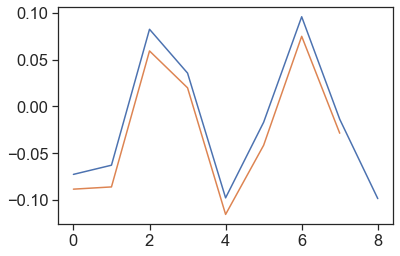

In [243]:
plt.plot(predicted_neural_activity[:,0])
plt.plot(act_matrix[:,0][1:])

In [248]:
cc = []
for i in range(n_neurons):
    cc.append(np.corrcoef(act_matrix[:,i],np.roll(predicted_neural_activity[:,i],1))[0,1])
    
print(np.mean(cc))

0.8175713735021003


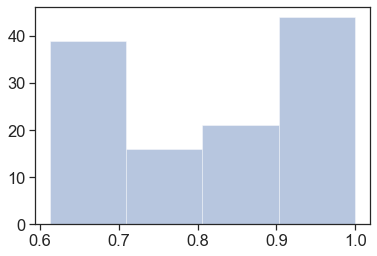

In [249]:
seaborn.distplot(cc,kde=0)

# check if simulated activity comes out as periodic

In [252]:
def fit_sin2(x,*params):
    t_ = np.linspace(0,2*np.pi,9)
    y = np.array(params)
    y -= np.mean(y)
    y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])#*x[2] + x[3]
    cc = np.corrcoef(pred,y)[0,1]
    if np.isnan(cc): cc = -100
    return -cc